# Lab 2

In [132]:
#Import modules
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [133]:
url = 'https://raw.githubusercontent.com/DAVE3625/DAVE3625-24H/refs/heads/main/Lab2/data/Titanic.csv'
df = pd.read_csv(url, sep=',')
df.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


### 1. Check for null and nan values

In [134]:
df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Fill Age, Fare and Embarked with sensible values. (Embarked could be filled with "S") Since the nan values are defined differently in this dataset, we can use the function right out of the box. What a meaningful value is differ from dataset to dataset, in this dataset the age value is right skewed, so we will use the median.

In [135]:
# mean age
print('Mean of "Age" is %.2f' %(df["Age"].mean(skipna=True)))
# median age
print('Median of "Age" is %.2f' %(df["Age"].median(skipna=True)))

Mean of "Age" is 29.88
Median of "Age" is 28.00


In [136]:
df["Age"] = df["Age"].fillna(df["Age"].median(skipna=True))
#there is only one value missing from fare, will fill in with zero
df["Fare"] = df["Fare"].fillna(0)
#there is only two values missing, so filling it with dummy data 
df["Embarked"] = df["Embarked"].fillna('S')


We can also see that many people has a NaN for Cabin. It’s not as easy as just fill a dummy value here. We could fill with “no cabin”, but for machine learning, we like to have numerical or bool values. To achieve this, lets make a new bool column:

Cabin = True / False And set all NaN values = False, all other = True

Adding a new column based on data available is considered creating a new feature.

In [137]:
df["HasCabin"] = df.Cabin.notnull()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False


Another viable approach would be to remove the entire Cabin Value from the dataset since 77% of the data is missing, which is highly determinal to the overall quality and integrity of the data.

I chose to drop the columns Cabin and HasCabin for those reasons. 

In [138]:
df = df.drop(['Cabin','HasCabin'], axis=1)

### 2. Adding a feature

We want to ectract the title for each person on the boat to make a new column called "Title". From looking at the dataset, the syntax for the names is LastName + Title + RestOfName

An easy way to extract a cartain string is to use regex.

In [139]:
df["Title"] = df.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
df["Title"].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Title, dtype: int64

There are 18 titles, some of them only having a couple of people. Mlle is the french equvalent of Miss, and Mme is like Mrs. Ms is a neutral alternative to Mrs or Miss. We replace those with its more common counterpart and create a "Unique" category for all the weirder titles. 

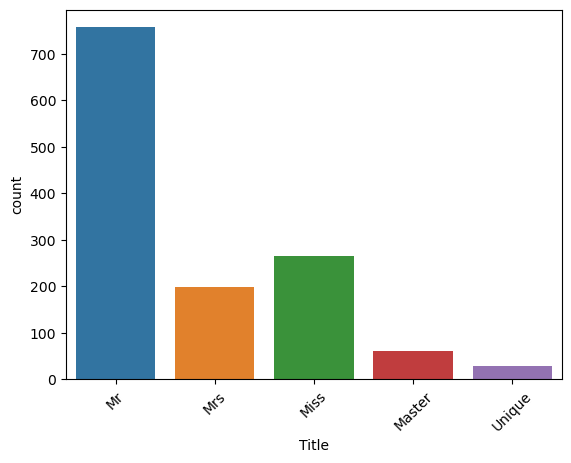

In [140]:
df["Title"] = df["Title"].replace({'Mlle':'Miss', 'Mme':'Mrs','Ms':'Miss'})
df["Title"] = df["Title"].replace(["Dona","Jonkheer","Countess","Capt","Don","Sir","Lady","Major","Col", "Dr","Rev"], "Unique")
sns.countplot(x='Title', data=df, hue="Title"); #seaborn countplot
plt.xticks(rotation=45);

### 3. Convert Age and Fare into categorical data

In [141]:
# qcut is used to discretize variables into equal-sized buckets, in order to create a categorical variable
# Think of it as creating 4 bins of age range 0, 1, 2, 3
df['CatAge'] = pd.qcut(df["Age"], q=4, labels=False )
df['CatFare'] = pd.qcut(df["Fare"], q=4, labels=False )
df.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,CatAge,CatFare
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr,3,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.0500,S,Mr,1,1
1308,1309,NaN,3,"Peter, Master. Michael J",male,28.0,1,1,2668,22.3583,C,Master,1,2


### 4. Convert the dataframe to binary data

To train a dataset easily, we want all the data to be numerical. To do this, we need to drop columns that don't make sense converting to a numerical value.

In [142]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,CatAge,CatFare
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S,Mr,0,0


In [143]:
df = df.drop(["Name", "Ticket", "Fare"], axis=1)
df.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,CatAge,CatFare
0,1,0.0,3,male,22.0,1,0,S,Mr,0,0


In [144]:
df = pd.get_dummies(df, drop_first=True) #Better to use OneHotEncoder() for machine learning tasks
df.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,CatAge,CatFare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Unique
0,1,0.0,3,22.0,1,0,0,0,1,0,1,0,1,0,0
1,2,1.0,1,38.0,1,0,3,3,0,0,0,0,0,1,0
2,3,1.0,3,26.0,0,0,1,1,0,0,1,1,0,0,0


### 5. Save the cleaned dataset to a new .csv file

In [145]:
df.to_csv('data/Titanic_Cleaned.csv', index=False)